# Evolution Analysis - Checkpoint Data

This notebook loads and analyzes evolutionary simulation data from the checkpointing system.

## Usage:
1. Run the data loading cell to automatically find the latest simulation results
2. Or specify a specific checkpoint directory: `data = load_checkpoint_history("evolution_checkpoints_TIMESTAMP")`
3. Run the plotting cells to visualize evolution dynamics

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import glob
from pathlib import Path

# Set up matplotlib for high quality plots
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Optional: Specify a checkpoint directory manually
# CHECKPOINT_DIR = "evolution_checkpoints_20250811_132116"  # Uncomment and set to load specific run
CHECKPOINT_DIR = None  # Use None to automatically find the latest

In [9]:
# Load simulation data from checkpoint directory
def load_checkpoint_history(checkpoint_dir=None):
    """Load history from checkpoint directory or find the most recent one"""
    if checkpoint_dir is None:
        # Find most recent checkpoint directory
        checkpoint_dirs = sorted([d for d in Path(".").glob("evolution_checkpoints_*") if d.is_dir()])
        if not checkpoint_dirs:
            raise FileNotFoundError("No checkpoint directories found. Run evolution_checkpoint.py first!")
        checkpoint_dir = checkpoint_dirs[-1]
    else:
        checkpoint_dir = Path(checkpoint_dir)
    
    print(f"Loading data from: {checkpoint_dir}")
    
    # Load complete history file
    history_file = checkpoint_dir / "complete_history.pkl"
    if history_file.exists():
        with open(history_file, 'rb') as f:
            data = pickle.load(f)
        return data
    
    # Fallback: load from latest checkpoint
    latest_checkpoint = checkpoint_dir / "latest_checkpoint.pkl"
    if latest_checkpoint.exists():
        with open(latest_checkpoint, 'rb') as f:
            checkpoint_data = pickle.load(f)
        return {
            'history': checkpoint_data['history'],
            'parameters': checkpoint_data['parameters'],
            'final_generation': checkpoint_data['generation'],
            'total_time': 0  # Not available in checkpoint
        }
    
    raise FileNotFoundError(f"No history files found in {checkpoint_dir}")

# Load the data
data = load_checkpoint_history(CHECKPOINT_DIR)
history = data['history']
parameters = data['parameters']
total_time = data.get('total_time', 0)
final_generation = data.get('final_generation', len(history['generation']) - 1)

print(f"\nSimulation parameters:")
for key, value in parameters.items():
    print(f"  {key}: {value}")
print(f"\nFinal generation: {final_generation}")
if total_time > 0:
    print(f"Total simulation time: {total_time:.2f} seconds")

FileNotFoundError: No checkpoint directories found. Run evolution_checkpoint.py first!

In [5]:
# Extract data for plotting
generations = history['generation']
w_g_distributions = history['w_g_distribution']
w_s_distributions = history['w_s_distribution']
mean_w_g = history['mean_w_g']
std_w_g = history['std_w_g']
mean_w_s = history['mean_w_s']
std_w_s = history['std_w_s']
mean_fitness = history['mean_fitness']

num_generations = len(generations)
print(f"Data loaded: {num_generations} generations")
print(f"Final w_g: mean={mean_w_g[-1]:.4f}, std={std_w_g[-1]:.4f}")
print(f"Final w_s: mean={mean_w_s[-1]:.4f}, std={std_w_s[-1]:.4f}")

NameError: name 'history' is not defined

NameError: name 'w_g_distributions' is not defined

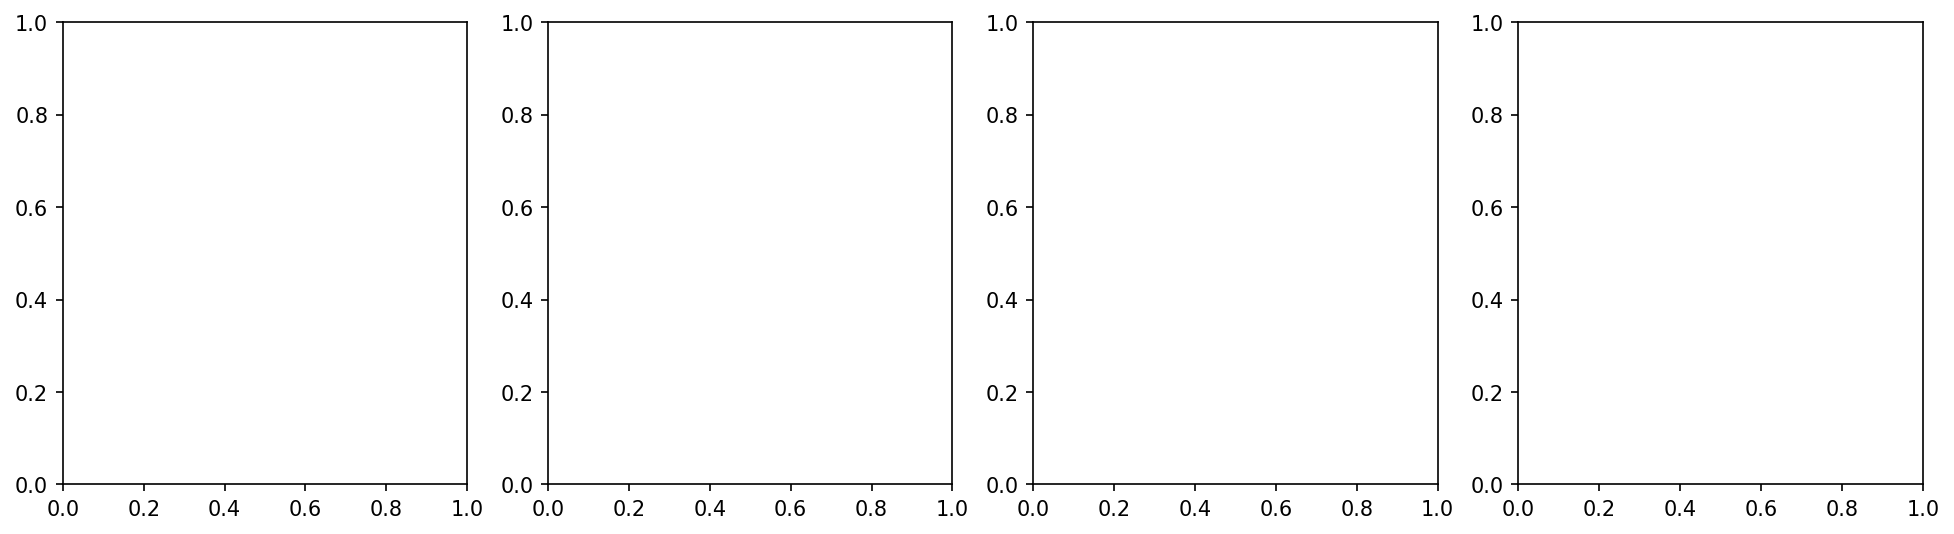

In [6]:
# Create Figure S2-style plot
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot 1: Gradient detection evolution (2D histogram)
if len(w_g_distributions) > 0:
    max_w_g = max(np.max(dist) for dist in w_g_distributions if len(dist) > 0)
    max_w_g = max(max_w_g, 2.0)  # Ensure reasonable scale
    
    gen_edges = np.linspace(0, num_generations, num_generations + 1)
    w_g_edges = np.linspace(0, max_w_g, 50)
    
    hist_data_g = np.zeros((len(w_g_edges) - 1, len(gen_edges) - 1))
    
    for i, w_g_dist in enumerate(w_g_distributions):
        if len(w_g_dist) > 0:
            hist, _ = np.histogram(w_g_dist, bins=w_g_edges)
            hist_data_g[:, i] = hist
    
    im_g = axes[0].imshow(hist_data_g, aspect='auto', origin='lower',
                         extent=[0, num_generations, 0, max_w_g], 
                         cmap='hot', interpolation='nearest',vmax=50)

    axes[0].set_xlabel('Generation')
    axes[0].set_ylabel('Gradient detection: ωg')
    axes[0].set_title('Gradient Detection Evolution')
    plt.colorbar(im_g, ax=axes[0], label='Individuals')

# Plot 2: Sociality evolution (2D histogram)
if len(w_s_distributions) > 0:
    max_w_s = max(np.max(dist) for dist in w_s_distributions if len(dist) > 0)
    max_w_s = max(max_w_s, 2.0)
    
    w_s_edges = np.linspace(0, max_w_s, 50)
    hist_data_s = np.zeros((len(w_s_edges) - 1, len(gen_edges) - 1))
    
    for i, w_s_dist in enumerate(w_s_distributions):
        if len(w_s_dist) > 0:
            hist, _ = np.histogram(w_s_dist, bins=w_s_edges)
            hist_data_s[:, i] = hist
    
    im_s = axes[1].imshow(hist_data_s, aspect='auto', origin='lower',
                         extent=[0, num_generations, 0, max_w_s],
                         cmap='hot', interpolation='nearest',vmax=50)
    axes[1].set_xlabel('Generation')
    axes[1].set_ylabel('Sociality: ωs')
    axes[1].set_title('Sociality Evolution')
    plt.colorbar(im_s, ax=axes[1], label='Individuals')

# Plot 3: Mean w_g over time with adaptive scaling
axes[2].plot(generations, mean_w_g, 'r-', linewidth=2, label='Mean ωg')
axes[2].fill_between(generations,
                    np.array(mean_w_g) - np.array(std_w_g),
                    np.array(mean_w_g) + np.array(std_w_g),
                    alpha=0.3, color='red', label='±1 std')

# Adaptive y-axis scaling for w_g
if len(mean_w_g) > 0:
    w_g_min = min(0, min(mean_w_g) - max(std_w_g))
    w_g_max = max(mean_w_g) + max(std_w_g)
    w_g_range = w_g_max - w_g_min
    
    # Add 10% padding, but ensure minimum range for visibility
    if w_g_range < 0.1:
        w_g_center = (w_g_max + w_g_min) / 2
        axes[2].set_ylim(w_g_center - 0.05, w_g_center + 0.05)
    else:
        axes[2].set_ylim(w_g_min - 0.1*w_g_range, w_g_max + 0.1*w_g_range)

axes[2].set_xlabel('Generation')
axes[2].set_ylabel('Mean ωg')
axes[2].set_title('Mean Gradient Detection')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot 4: Mean w_s over time with adaptive scaling
axes[3].plot(generations, mean_w_s, 'b-', linewidth=2, label='Mean ωs')
axes[3].fill_between(generations,
                    np.array(mean_w_s) - np.array(std_w_s),
                    np.array(mean_w_s) + np.array(std_w_s),
                    alpha=0.3, color='blue', label='±1 std')

# Adaptive y-axis scaling for w_s
if len(mean_w_s) > 0:
    w_s_min = min(0, min(mean_w_s) - max(std_w_s))
    w_s_max = max(mean_w_s) + max(std_w_s)
    w_s_range = w_s_max - w_s_min
    
    # Add 10% padding, but ensure minimum range for visibility
    if w_s_range < 0.1:
        w_s_center = (w_s_max + w_s_min) / 2
        axes[3].set_ylim(w_s_center - 0.05, w_s_center + 0.05)
    else:
        axes[3].set_ylim(w_s_min - 0.1*w_s_range, w_s_max + 0.1*w_s_range)

axes[3].set_xlabel('Generation')
axes[3].set_ylabel('Mean ωs')
axes[3].set_title('Mean Sociality')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Update title to use available parameters
pg_val = parameters.get("pg", "N/A")
num_agents_val = parameters.get("num_agents", "N/A") 
title_time = f", {total_time:.1f}s" if total_time > 0 else ""

plt.suptitle(f'Evolution Dynamics: pg={pg_val}, N={num_agents_val}, ' 
            f'{final_generation+1} generations{title_time}', fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
# Analyze final population for bifurcation
if len(w_g_distributions) > 0:
    final_w_g = w_g_distributions[-1]
    final_w_s = w_s_distributions[-1]
    
    
    
    # Plot final population scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(final_w_g, final_w_s, alpha=0.6, s=30)
    plt.xlabel('Gradient detection (ωg)')
    plt.ylabel('Sociality (ωs)')
    plt.title('Final Population Distribution')
    plt.grid(True, alpha=0.3)
    
    # Add lines to show threshold
    # plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='w_g = 0.5')
    # plt.axhline(y=0.5, color='blue', linestyle='--', alpha=0.5, label='w_s = 0.5')
    plt.legend()
    plt.show()
    

NameError: name 'w_g_distributions' is not defined

In [ ]:
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

final_w_g = []
final_w_s = []
for i in range(320):
    if i % 3 == 0:
        final_w_g.append(max(np.random.normal(0.3,0.1),0))
        final_w_s.append(max(np.random.normal(0.05,0.002),0))
    else:
        final_w_s.append(max(np.random.normal(0.45,0.1),0))
        final_w_g.append(max(np.random.normal(0.05,0.002),0))

population = []
for wg,ws in zip(final_w_g,final_w_s):
    population.append({"w_g":wg,"w_s":ws})

def pdf(w_gs, mu0,mu1, cov0, cov1, weight):
    return weight*multivariate_normal.pdf(w_gs,mu0,cov0) + (1-weight)*multivariate_normal.pdf(w_gs,mu1,cov1)

def neg_log_likelihood(mu0_0,mu0_1,mu1_0,mu1_1,cov0_11,cov0_12,cov0_21,cov0_22,cov1_11,cov1_12,cov1_21,cov1_22,weight, population=population):
    mu0 = np.array([mu0_0, mu0_1])
    mu1 = np.array([mu1_0, mu1_1])
    cov0 = np.array([[cov0_11,cov0_12],[cov0_21,cov0_22]])
    cov1 = np.array([[cov1_11,cov1_12],[cov1_21,cov1_22]])
    ell = 1
    for p in population:
        ell += np.log(pdf([p["w_g"],p["w_s"]], mu0, mu1, cov0,cov1, weight))
    return -ell

wrap =lambda x: neg_log_likelihood(*x, population=population)

inital_guess = (0.0,0.3,0.3,0.3,0.1,0,0.1,0,0.1,0,0,0.1,0.75)

wrap(inital_guess)
# minimize(wrap,inital_guess)


AttributeError: 'multinomial_gen' object has no attribute 'pdf'

0.04807566236696325